# PROCESSAMENTO DIGITAL DE SINAIS

# Sumário

1. [Complexidade computacional](#complexidadecomputacional)

    1.1.[Numba](#numba)

2. [Convolução](#convolution)
3. [Equações de diferença](#diferenceequations)
4. [Amostragem de sinais de tempo contínuo](Sampling)

    4.1. [Teorema da amostragem](SamplingTheorem)


<a id="complexidadecomputacional"></a>
# Complexidade Computacional

A complexidade computacional mede o quão custoso é um algoritmo, tanto em questão de uso de recursos, como capacidade de processamento e memória, como em termos de tempo de execução. No contexto de processamento digital de sinais, essa métrica é importante, pois em geral, algoritmos de PDS lidam com sinais em tempo real, em hardware com recursos limitados, e portanto presisam operar rapidamente, de forma a não comprometer a comunicação, não esgotar os recursos disponíveis, e manter a qualidade do sinal e a menor latência possível.

Para isso, é necessário estabelecer a métrica dessa complexidade, e buscar formas, como avaliar diferentes algoritmos para determinado processamento de modo a reduzir o uso de recursos e otimizar o código. Em geral, obtém-se o nível de complexidade do aloritmoa  partir da quantidade de operações realizadas, que depende diretamente do tamanho do objeto que passa pelo processamento. Observar e analisar como o número de operações cresce conforme se aumenta o tamanho e a dimensão do objeto é o que determina o quão complexo é tal algoritmo.

Esse fator serão estudados esse fator de complexidade e técnicas de aceleração de código ao longo dessa capcitação.

## Numba

Numba é uma biblioteca open-source para Python que funciona como um compilador just-in-time (JIT), traduzindo na hora um subconjunto de código Python e operações NumPy para código de máquina otimizado via *low level virtual machine* (LLVM), um *framework* modular de compilação. Um compilador JIT traduz os trechos de código para código de máquina otimizado em tempo de execução, diferentemente de um compilador  *ahead-of-time* (AOT), que compila tudo antes de executar. O numba utiliza a representação intermediária de baixo nível e o backend para gerar o código de máquina para diferentes arquiteturas, como x86 e ARM, fornecidos pelo framework para transformar o código em python em instruções de processador altamente otimizadas.

O numba oferece dois decoradores principais para a compilação:

**@jit** e **@njit**

O decorador usa LLVm para converter uma função em python na primeira vez que ela é chamada. Os principais parâmetros são:
- nopython
    - *True*, força o Numba a compilar todo o código em máquina. Se encontrar trechos não suportados, levanta erro em vez de recorrer ao   interpretador Python. Equivalente a utilizar o atalho *njit*
    - *False*, partes não suportadas caem no “object mode”, mantendo a compatibilidade mas reduzindo a velocidade. 

- nogil
    - *True*, o código compilado libera o GIL (Global Interpreter Lock), permitindo threads paralelos que executem a função simultaneamente.
    - *False*, a função ainda respeita o GIL.

- parallel
    - *True*, ativa otimizações automáticas para loops paralelos (análise de dependências e vetorização). Geralmente usado em conjunto com prange em loops *for*.

- cache
    - *True*, armazena em disco o código compilado para que invocações futuras (mesma versão de função) sejam resgatadas sem recompilação. Útil em startups frequentes de scripts longos.

- fastmath
    - *True*, aplica otimizações aritméticas agressivas (ignore NaNs, associações de ponto flutuante, etc.). Pode alterar ligeiramente o resultado numérico em troca de mais performance.

- signature (ou tipos)
     - Recebe uma tupla de tipos para argumentos e tipo de retorno, por exemplo @jit("float64(int32, float32)"). Compila versões especializadas antecipadamente, evitando inferência de tipos em tempo de execução.

- locals
    - Dicionário para anotar explicitamente tipos de variáveis locais, ajudando a guiar a inferência quando ela falha ou fica ambígua.

É possível também aproveitar a GPU em seus cálculos Python, você pode usar o módulo numba.cuda. Ele permite compilar funções Python em kernels CUDA, gerenciar memória na placa e lançar paralelismo massivo diretamente do seu código. Para isso, deve-se utilizar o decorador:

**@cuda.jit**

- threads_per_block: ´Número de threads por bloco, que depende do harware.

- block_per_grid: Quantos blocos lançar para cobrir todos os elementos.

<a id="convolution"></a>
# Convolução

A soma de convolução é uma operação de suma importância no contexto de processamento digital de sinais. A partir dessa operação , é possível determinar a saída de um sistema linear qualquer, bastando conhecer a resposta que esse sistema retorna  quando aplicamos um impulso à sua entrada. Dessa forma, podemos escrever a saída do sistema linear disscreto $y(n)$ como:

$$y(n) = \sum _{l = -\infty}^\infty x(k) h(n-k)$$

Ou seja, a saída do sistema é equivalente ao resultado da convolução da entrada $x(n)$ com a aresposta ao impulso do sistema $h(n)$

O exemplo abaixo define um sistema $H(x)$ que desloca o sinal de entrada $x$ em 100 amostras. Em seguida, obtém-se o sinal resposta ao impulso desse sistema $h_n$ ao aplicar um impulso como entrada ao sistema. Em seguida, a função *Conv_sum* realiza a soma de convolução entre um pulso retangular e a resposta ao impulso do sistema H. Note que o pulso é deslocado no tempo para a posição do impulso atrasado. Essa é a saída do sistema caso seja aplicado um pulso retangular à sua entrada.

A soma de convolução de sinais discretos retona um sinal que possui uma duração em $t$ de $M-1+N-1$ amostras. Assim, para que o sinal de saída tenha o mesmo tamanho do sinal de entrada, é necessário eliminar valores das extremidades do sinal de saída e obter apenas os vaores centrais. Essa escolha é permitida na função, a partir da escolha do parâmetro *mode*. 

A complexidade da convolução como é feita no exemplo é obtida a partir do cálculo da quantidade de operações. A função é feita a partir de dois laços, onde o laço externo roda M+N-1 vezes e o laço interno roda N vezes, de modo que a quantidade de operações obedece uma relação que varia com $N^2$.

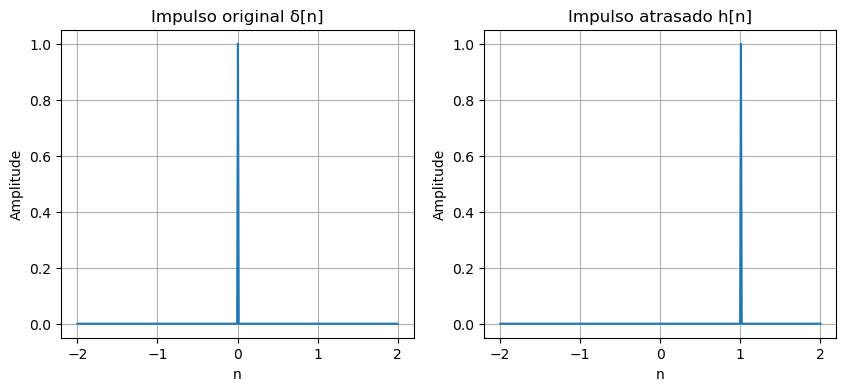

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

f_s = 100  # Frequência de amostragem em Hz
N = 4*f_s  # Número de amostras
T = 1  # Tempo de deslocamento em segundos
n = np.linspace(-2, 2, N)
x_n = np.where(np.abs(n) < 0.5, 1, 0)

idx0= np.argmin(np.abs(n-0.0)) # Índice do impulso unitário

# Impulso unitário
delta = np.zeros_like(n)    
delta[idx0] = 1

def H(x, T, f_s):
    """
    Função que desloca o sinal de entrada em 100 amostras.

    Args:
        x (np.ndarray): Sinal de entrada.
        T (float): Deslocamento do sinal em segundos.
        f_s (int): Frequência de amostragem do sinal.
    Returns:
        np.ndarray: Sinal deslocado.
    """
    d = int(f_s * T)  # Deslocamento em amostras
    N = len(x)
    y = np.zeros_like(x)
    if(f_s * T >= N):
        raise ValueError("O deslocamento T é muito grande para o tamanho do sinal.")
    y[d:N] = x[:N-d]
    return y

h_n = H(delta, T, f_s)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Impulso original
axs[0].plot(n, delta)
axs[0].set_title('Impulso original δ[n]')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Impulso atrasado
axs[1].plot(n, h_n)
axs[1].set_title('Impulso atrasado h[n]')
axs[1].set_xlabel('n')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)


plt.show()

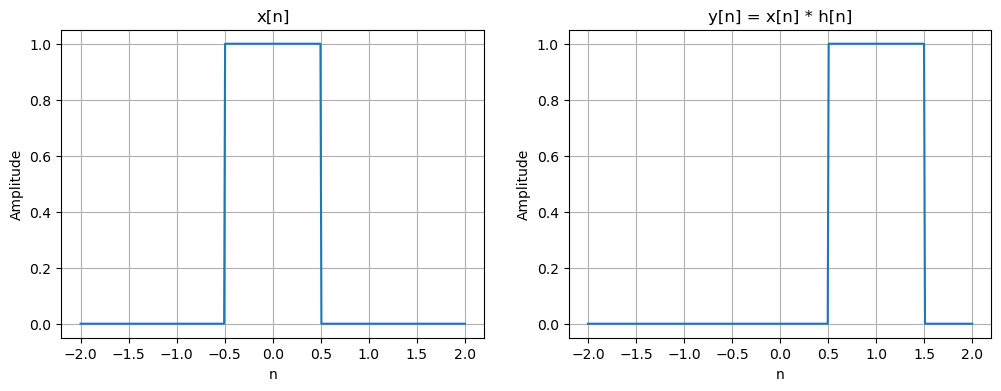

In [14]:
def Conv_sum(x, h, mode='full'):
    """
    Função que calcula a convolução de dois sinais x e h.

    A convolução retorna um sinal de tamanho (M+N-1). Isso se deve ao fato da convolução deslocar o sinal de N amostras em M amostras, ou seja, o índice do sinal resultante começa em 0, e segue até (N-1)+(M-1),
    totalizando N+M-1 índices, ou amostras.

    Caso o modo seja 'full', a função retorna o resultado completo da convolução.
    Caso o modo seja 'same', a função retorna apenas a parte dentral do resultado com o mesmo tamanho do sinal de entrada x.

    args:
        x (np.ndarray): Sinal de entrada.
        h (np.ndarray): Resposta ao Impulso.
        mode (str): Modo da convolução, pode ser 'full' ou 'same'.
    returns:
        np.ndarray: Sinal resultante da convolução.
    """
    N = len(x)
    M = len(h)
    y = np.zeros(N + M - 1)

    for n in range(N + M - 1):
            for k in range(N):
                  y[n] += x[k] * h[n-k] if 0 <= n - k < M else 0
    
    if mode == 'full':
        return y                                #y = np.convolve(x_n, h_n, mode='full')
    elif mode == 'same':
        begin = ceil((M-1)/2)
        return y[begin:begin + N]         #y = np.convolve(x_n, h_n, mode='same')

#y_n = Conv_sum(x_n, h_n)
y_same = Conv_sum(x_n, h_n, mode='same')

t = np.linspace(-2, 2, len(y_same))

# plotando os resultados
fig, axs = plt.subplots(1,2,figsize=(12, 4))
axs[0].plot(n, x_n)
axs[0].set_title('x[n]')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

axs[1].plot(t, y_same)
axs[1].set_title('y[n] = x[n] * h[n]')
axs[1].set_xlabel('n')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)


plt.show()





# Equações de Diferenças

Um sistema discreto pode ser representado pelo que é denominado de equações de diferenças. Essas equações definem a relação entre a saída e a entrada de um sistema discreto genérico da seguinte forma, segundo (Gal & Roberts, 1980):

$$
\sum_{i = 0}^N a_i y(n-i) - \sum_{l = 0}^N b_l x(n-l) = 0
$$

Essa equação admite infinitas soluções $y(n)$, e são necessárias N condições auxiliares para determinar a solução da equação de diferenças, onde N é a ordem da equação. Isolando o termo de interesse $y(n)$ na equação acima, nós obtemos:

$$
a_0y(n) = \sum_{l = 0}^N b_l x(n-l) - \sum_{i = 1}^N a_i y(n-i)
$$

De modo que, conhecendo o sinal discreto x, os parâmetros a e b, e N conições auxiliares de y, pode-se encontrar o sinal discreto que é solução da equação de diferenças. 

O exemplo abaixo ilustra esse comportamento ao definir a função *pyfilter*, semelhante à função *filter* do MATLAB. Na função abaixo, o sistema é considerado inicialmente em repouso, de modo que as condições auxiliares são consideradas nulas. 

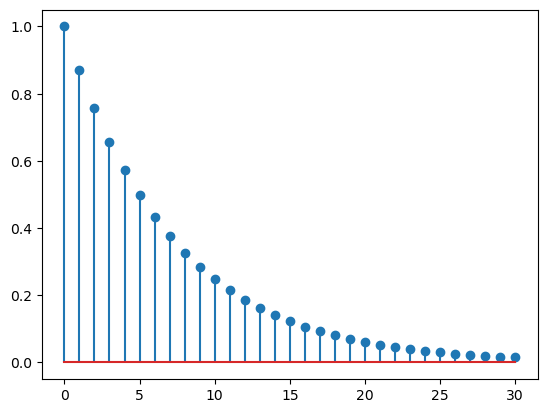

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pyfilter(b, a, x):
    """Função que obtém a saída de um sistema representado por uma equação de diferenças com oeficiente b e a, e entrada x, 
        para um sistema inicialmente em repouso.
    Args:
        b (list): Coeficientes do numerador da equação de diferenças.
        a (list): Coeficientes do denominador da equação de diferenças.
        x (list): Sinal de entrada.
    Returns:
        y: Sinal de saída.
    """
    N = len(x)
    M = len(b)
    L = len(a)
    y = np.zeros(N)  # Inicializa o vetor de saída com zeros

    for n in range(N):

        x_pond = sum(b[k] * x[n-k] for k in range(M) if n-k >= 0)
        
        y_pond = sum(a[k] * y[n-k] for k in range(1, L) if n-k >= 0)
        y[n] = x_pond - y_pond

    return y # y = lfilter(b, a, x, z_i = NULL)

alpha = 1.15
N = 30
x = np.r_[1, np.zeros(N)]
b = [1]
a = [1, -1/alpha]

y_custom = pyfilter(b, a, x)


plt.stem(y_custom)
plt.show()


# Amostragem de sinais no tempo contínuo

Com o objetivo de realizar o processamento digital de um sinal, que naturalmente é contínuo, é necessário, a priori, digitalizar esse sinal, coletando amostras desse sinal contínuo em intervalos de amostragem, de modo a obtermos um sinal discreto no tempo da forma:

$$
x(n) = x_a(nT)
$$

A partir disso, podemos definir um sinal no tempo contínuo formado por um trem de impulsos escalados pela amplitude das amostras de $x(n)$ (Ou de x(t)) nos instantes de amostragem T, de modo que :

$$
x_i(t) = \sum_{n = -\infty}^\infty x(n)\delta(t-nT)
$$

Em que $\delta(t)$ é o impulso unitário dado por:

$$
\begin{cases}
\delta(t) = 0, & t \neq 0,\\
\displaystyle\int_{-\infty}^{\infty}\delta(t)\,\mathrm{d}t = 1
\end{cases}
$$

Sabendo que a transformada de Fourier de um sinal $x(t)$ é dada por:

$$
X(j\omega) = \int_-\infty^\infty x(t)e^{-j\omega t} dt
$$

E que uma de suas propriedades estabelece que o espectro de um produto entre dois sinais é equivalente à convolução dos espectros dos sinais individuais, podemos escrever a transformada de Fourier do sinal $x_i(t)$ como:


$$
X_i(j\omega)
=
\frac{1}{2\pi}\;X_a(j\omega)\;\ast\;P(j\omega)
=
\frac{1}{2\pi}
\int_{-\infty}^{\infty}
X_a\bigl(j\omega - j\omega'\bigr)\,
P(j\omega')\,
\mathrm{d}\omega'
$$

Em que $P(j\omega)$ é o trem de impulsos unitários nos intervalos de amostragem. 

## Teorema da amostragem
A interpretação dessa questão é de que o espectro de um sinal discreto é periódico na frequência de amotragem do sinal, de modo que o espectro do sinal contínuo original é replicado nas frequências múltiplas da frequência de amostragem do sinal. É impostante que para recuperarmos o sinal contínuo original, devemos ser capazes de identificar e obter o seu espectro individualmente. Isso exige que o espectro das cópias não se sobreponham, pois será impossível de saber qual o formato do espectro do sinal original. para isso, é necessário que ele possua largura de banda limitada. 

Além disso, considere que a maior frequência do sinal seja $\Omega$. Isso significa que, a banda ocupada pelo espectro de cada cópia será: $f-s-\Omega + f_s + \Omega$, ou seja, o espectro ocupa uma banda de frequências de largura $2\Omega$ centralizada em cada múltiplo da frequência de amostragem. De modo que para que possamos identificar o espectro do sinal original, ou seja, que não haja sobreposiçõ, deve ser escolhida uma frequência adequada para amostrar o sinal, de pelo menos $2\Omega$. Pois assim, a banda à direita do espectro da cópia centrada em $f_s$ não se sobrepunhará à extremidade esquerda do espectro centrado em $2f_s$.

A frequência mínima necessária para recuperar o sinal $2\Omega$ é denominada Frequência de Nyquist.

O exemplo abaixo ilustra como amostrar diferentes sinais contínuos pode gerar o mesmo sinal discreto, como isso se reflete nos espectros de cada sinal, e o processo de recuperação do sinal original.




<Figure size 1000x400 with 0 Axes>

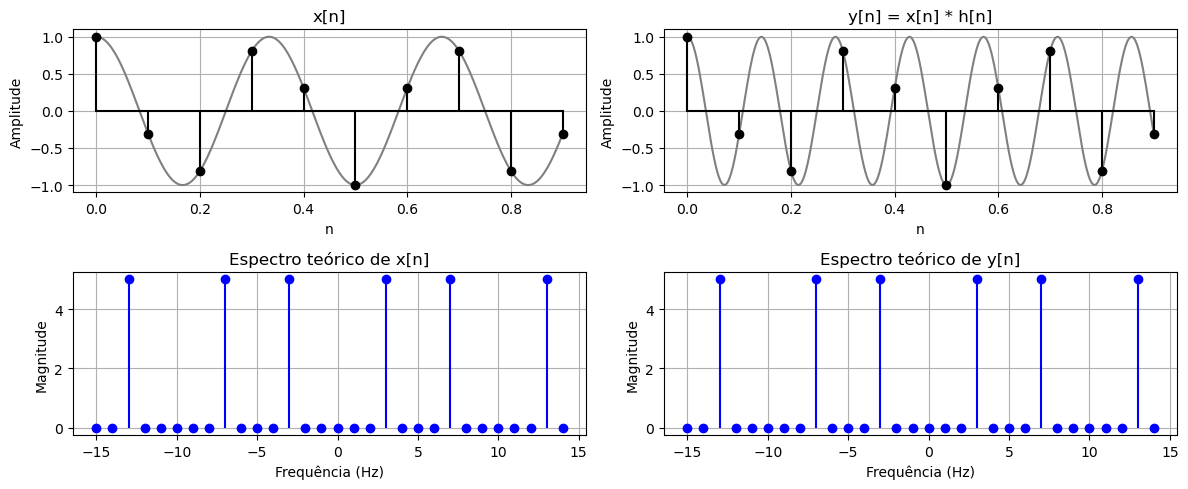

In [138]:
import numpy as np
import matplotlib.pyplot as plt

fs = 10 # frequência de amostragem
k = 1 # número de ciclos
f03 = 3
f07 = 7
N3 = int(k*3 * fs/f03)
N7 = int(k*7 * fs/f07)
t3 = np.arange(N3) / fs
t7 = np.arange(N7) / fs

x = np.cos(2*np.pi*f03*t3)
x_2 = np.cos(2*np.pi*f07*t7)

t_total3 = np.linspace(0, np.argmax(t3)/fs, 300)
t_total7 = np.linspace(0, np.argmax(t7)/fs, 300)

x_original = np.cos(2*np.pi*3*t_total3)
x_2_original = np.cos(2*np.pi*7*t_total7)

plt.figure(figsize=(10, 4))

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

axs[0,0].plot(t_total3, x_original, label='Sinal contínuo', color = 'gray')
stem1 = axs[0,0].stem(t3, x)
plt.setp(stem1.markerline, color='black')
plt.setp(stem1.stemlines, color='black')
plt.setp(stem1.baseline, color='black')
axs[0,0].set_title('x[n]')
axs[0,0].set_xlabel('n')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].grid(True)

# Segundo subplot
axs[0,1].plot(t_total7, x_2_original, label='Sinal contínuo', color = 'gray')
stem2 = axs[0,1].stem(t7, x_2)
plt.setp(stem2.markerline, color='black')
plt.setp(stem2.stemlines, color='black')
plt.setp(stem2.baseline, color='black')
axs[0,1].set_title('y[n] = x[n] * h[n]')
axs[0,1].set_xlabel('n')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].grid(True)


X3 = np.fft.fft(x)
X7 = np.fft.fft(x_2)

# eixo de frequências original
f3 = np.fft.fftfreq(N3, d=1/fs)
f7 = np.fft.fftfreq(N7, d=1/fs)

# 4) Replicação periódica do espectro (±fs)
f_rep3  = np.hstack([f3 - fs, f3, f3 + fs])
f_rep7  = np.hstack([f7 - fs, f7, f7 + fs])
X3_rep = np.tile(np.abs(X3), 3)
X7_rep = np.tile(np.abs(X7), 3)

axs[1,0].stem(f_rep3, X3_rep, 
         linefmt='b-', markerfmt='bo', basefmt=" ",
         label='cos(2π·3t)')
axs[1,0].set_title('Espectro teórico de x[n]')
axs[1,0].set_xlabel('Frequência (Hz)')
axs[1,0].set_ylabel('Magnitude')
axs[1,0].grid(True)

axs[1,1].stem(f_rep7, X7_rep, 
         linefmt='b-', markerfmt='bo', basefmt=" ",
         label='cos(2π·7t)')
axs[1,1].set_title('Espectro teórico de y[n]')
axs[1,1].set_xlabel('Frequência (Hz)')
axs[1,1].set_ylabel('Magnitude')
axs[1,1].grid(True)

plt.tight_layout()
plt.show()



Note que ambos os sinais possuem o mesmo espectro, uma vez que par-te-se do mesmo sinal digital. No entanto, isso ocorre porque a extremidade esquerda da cópia do espectro do $cos(2\pi 7 t)$  centrada na frequência $f_s$, posicionada em: $\Omega = 10 - 7 = 3$ está à esquerda da estremidade direita do espectro do sinal original centrada em 0, pois $0+7 = 7$ Isso significa que há sobreposião os espectros, e que quando tentarmos recuperar os sinais a partir do uso de um filtro passa-baixas, obteremos um sinal diferente de $cos(2 \pi 7 t)$.

Para isso, definimos a resposta em frequência de um filtro passa-baixas ideal de frequência de corte $f_c$:

$$
H(f) = 
\begin{cases}
1, & |f| \leq f_c \\
0, & |f| > f_c
\end{cases}
$$

A resposta ao impulso \( h(t) \) é obtida pela transformada inversa de Fourier de $H(f)$:

$$
h(t) = 2f_c \cdot \text{sinc}(2\pi f_c t)
$$

Ao aplicarmos o filtro passa-baixas ao sinal discreto x(n), nós obtemos a relação:

$$
y(t) = x(n) * h(t) = \mathcal{F}^{-1}\{X(f) \cdot H(f)\} 
$$

Como a transfomada de Fourier do sinal original é equivalente ao espectro centrado em 0, excluindo-e as cópias nas frequências múltiplas da frequência de amostragem, podemos dizer que $x(t) = y(t)$. Portando, a soma de convolução entre o sinal discreto e a resposta ao impulso do filtro passa-baixas é equivalente ao sinal original. Como vimos anteriormente, a convolução de um sinal qualquer com um trem de impulsos resulta em cópias deste sinal deslocado para o instante do impulso, de tal forma que:

$$
y(t) = x(t) = \sum_{n = -\infty}^\infty x(n) \cdot sinc(2\pi f_c(t-nT))
$$




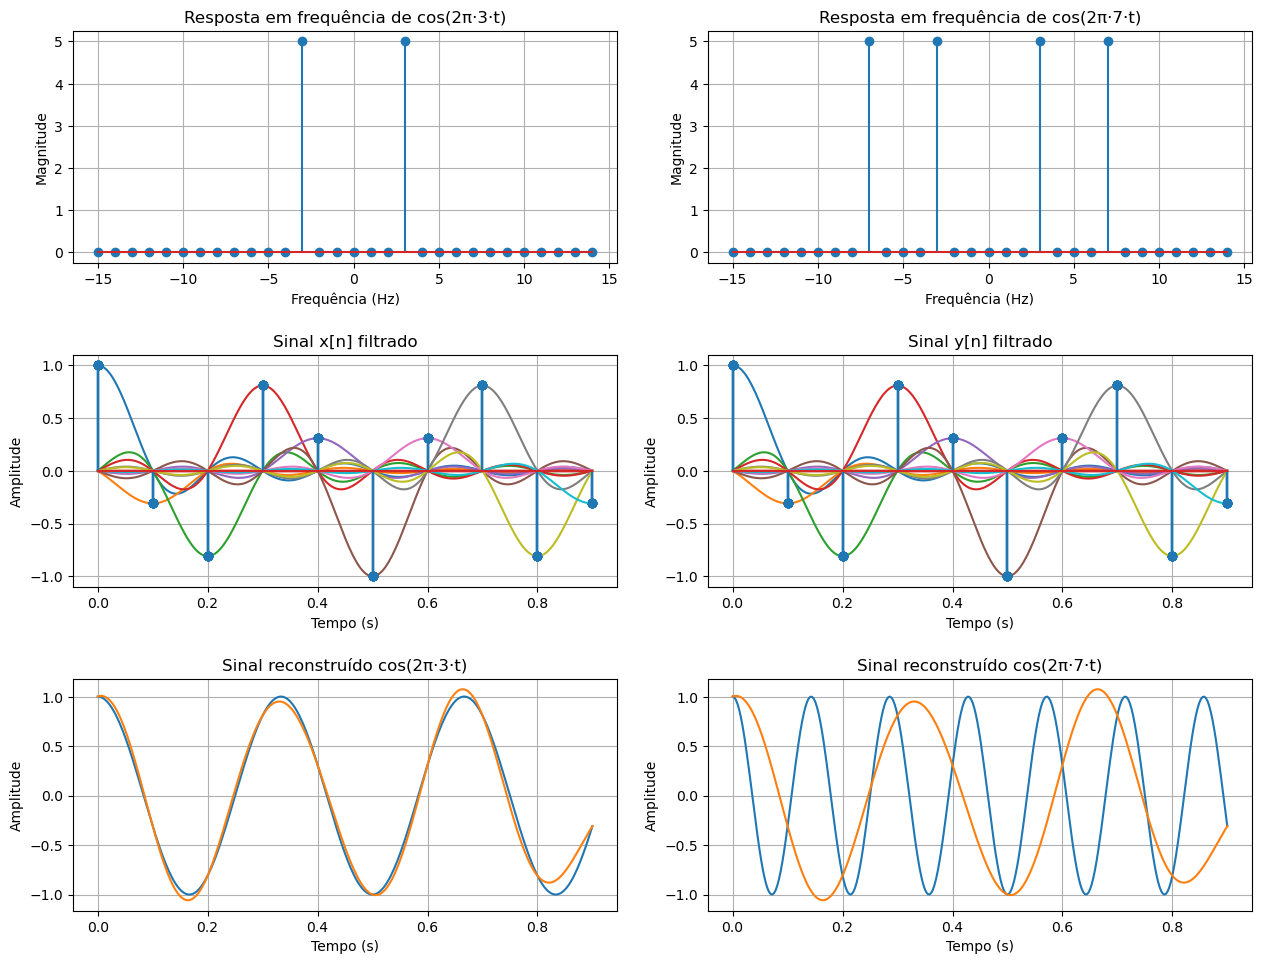

In [139]:
import numpy as np
import matplotlib.pyplot as plt
# Resposta em frequência dos filtros passa-baixas para f_c = 3Hz e 7 Hz
H3 = np.where(np.abs(f_rep3) <= 3, 1, 0)
H7 = np.where(np.abs(f_rep7) <= 7, 1, 0)

Y3 = X3_rep * H3
Y7 = X7_rep * H7

#t7_rec = np.arange(3*N7) / fs

#y7 = np.fft.ifft(Y7)
#y7 = np.real(y7)

fig, axs = plt.subplots(3, 2, figsize=(13, 10))

axs[0,0].stem(f_rep3, Y3, label='Resposta em frequência para f_c = 3Hz')
axs[0,0].set_title('Resposta em frequência de cos(2π·3·t)')
axs[0,0].set_xlabel('Frequência (Hz)')
axs[0,0].set_ylabel('Magnitude')
axs[0,0].grid(True)

axs[0,1].stem(f_rep7, Y7, label='Resposta em frequência para f_c = 7Hz')
axs[0,1].set_title('Resposta em frequência de cos(2π·7·t)')
axs[0,1].set_xlabel('Frequência (Hz)')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].grid(True)

x_rec = np.zeros_like(t_total3)
x2_rec = np.zeros_like(t_total7)


for n in range(N3):
    x_h = x[n] * np.sinc(fs*(t_total3 - n/fs))


    axs[1,0].plot(t_total3, x_h, label=f'x[n={n}]')
    axs[1,0].stem(t3, x)

    x_rec += x_h
    
for i in range(N7):
    x2_h = x_2[i] * np.sinc(fs*(t_total7 - i/fs))
    axs[1,1].plot(t_total7, x2_h, label=f'y[n={i}]')
    axs[1,1].stem(t7, x_2)

    x2_rec += x2_h



axs[1,0].set_title('Sinal x[n] filtrado')
axs[1,0].set_xlabel('Tempo (s)')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].grid(True)

axs[1,1].set_title('Sinal y[n] filtrado')
axs[1,1].set_xlabel('Tempo (s)')
axs[1,1].set_ylabel('Amplitude')
axs[1,1].grid(True)

axs[2,0].plot(t_total3, x_original, label=f'x[n={n}]')
axs[2,0].plot(t_total3, x_rec, label='Sinal reconstruído cos(2π·3·t)')
axs[2,0].set_title('Sinal reconstruído cos(2π·3·t)')
axs[2,0].set_xlabel('Tempo (s)')
axs[2,0].set_ylabel('Amplitude')
axs[2,0].grid(True)

axs[2,1].plot(t_total7, x_2_original, label=f'y[n={n}]')
axs[2,1].plot(t_total7, x2_rec, label='Sinal reconstruído cos(2π·7·t)')
axs[2,1].set_title('Sinal reconstruído cos(2π·7·t)')
axs[2,1].set_xlabel('Tempo (s)')
axs[2,1].set_ylabel('Amplitude')
axs[2,1].grid(True)
fig.tight_layout(pad=2.0)


Note que o espectro da senoide em 7Hz, após passar pelo filtro passa-baixa, representa o espectro de uma soma de sinais: $cos(2\pi 3t) + cos(2\pi 7 t)$. Amostrar esse sinal a 10 Hz resulta na mesma sequência de amostras de um sinal de 3Hz, de modo que, ao aplicarmos a interpolação, obtemos o mesmo sinal de 3Hz.